# Business Inteligence Sheet 1

### Juan David Camacho
### Hernán Russi
### Juan Esteban Daza  

### Exercise 1 
(1 Point) Create an example (figure with explanation) that shows how K-Means
will update a clustering C in such a way that one cluster becomes empty even though it had
at least one point in C.
Hint: Use a case with two attributes (it’s not possible with one attribute).


Tenemos un grupo de futbolistas a los cuales se les analiza la cantidad de goles y asistencias en la ultima temporada, los cuales, según se puede observar, se podrian encontrar en dos distintos grupos, por lo que vamos a comprobar que para un K = 3 puede quedar un clúster vacio debido a la distancia de los puntos a los centroides hallada tras las iteraciones del algoritmo K-Means.

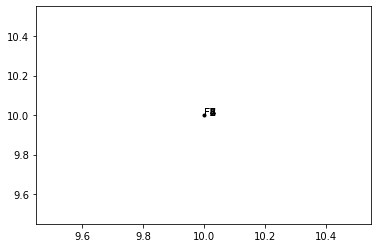

In [39]:
from matplotlib import pyplot as plt
import numpy as np
import random

datos=["F1","F2","F3","F4","F5","F6","F7","F8"]

x= 10
y= 10

plt.scatter(x, y, marker=".", color="black")
for i, label in enumerate(datos):
    plt.annotate(label, (x,y))

### Exercise 2 (4 Points)
1. Write a function kMeans(A, k, eps, mu = None) that runs the kMeans algorithm on
a given 2D-numpy array A with k clusters and termination criterion eps. If no initial
centroids mu are given, use random points in the range of the dataset. Make sure that
new (random) cendroids are created for clusters that become empty.
Let the function return a pair C, mu where C is a list that defines for each instance in
D its cluster (number). mu should be a list of k elements, containing the means of the
respective clusters.

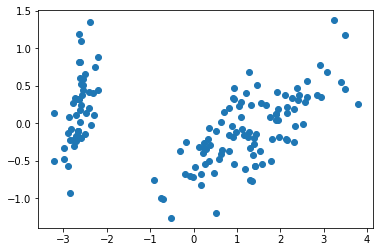

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import random
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
Iris_pca = pd.read_csv("iris_pca.csv")
plt.scatter(Iris_pca.X1, Iris_pca.X2)
iris_numpy = Iris_pca.to_numpy()

In [4]:
print(math.dist((-0.7514671406482273, 0.0785191864293572), (-2.6842071251039497,0.32660731476438853)))
print(math.dist((-2.2088329541767044, -0.1243604202222778), (-2.6842071251039497,0.32660731476438853)))

1.948597333195005
0.6552499526011198


In [5]:

def kMeans(A, k, eps, mu=None):
    centroids = []
    if mu is None:
        centroids = [[random.choice(A[:, 0]), random.choice(A[:, 1])]
                     for x in range(k)]
    else:
        centroids = mu

    dist = cdist(A, centroids, 'euclidean')
    c = np.array([np.argmin(i) for i in dist])

    while True:
        total = 0
        old_centroids = centroids
        centroids = []
        for kID in range(k):
            new_cent = A[c == kID].mean(axis=0)
            centroids.append(new_cent)
        dist = cdist(A, centroids, 'euclidean')
        c = np.array([np.argmin(i) for i in dist])
        for s in range(k):
            total += (centroids[s] - old_centroids[s])**2
        if (total[0] <= eps and total[1] <= eps):
            break
    
    return c, centroids


2. Write a function EM(A, k, eps, mu = None, cov = None, independent = False) that
conducts the expectation maximization algorithm on a given 2D-numpy array A with k
clusters and termination criterion eps. If no initial centroids mu are given, use random
points in the range of the dataset. If covariance matrices cov are given, use them instead
of the identity. If independent is set to True, treat the attributes as independent when
estimating the cluster co-variance matrices.
Let the function return a quartet w, mu, cov, P, where w is the assignment probability matrix (one line per point, one column per cluster), and mu, and cov are lists of
means/co-variance matrices of the k clusters. P should be the a-priori probabilities of
the clusters.
Hint: Check that the weights for each instance sum up to 1 after the expectation step.

In [44]:
def EM(A, k, eps, mu=None, cov=None, independent=False):

    # Initialization step
    centroids = []
    covariances = []
    if mu is None:
        centroids = [[random.choice(A[:, 0]), random.choice(A[:, 1])]
                     for x in range(k)]
    else:
        centroids = mu

    A_rows, A_cols = A.shape
    if cov is None:
        covariances = [np.identity(A_cols) for x in range(k)]
    else:
        covariances = cov

    prior_probs = [1/k for x in range(k)]

    w = np.empty([A_rows, k])
    while True:
        total = 0
        old_centroids = centroids
        # Expectation step
        for i in range(0, k):
            for j in range(0, A_rows):
                wij_abajo = 0
                punto = [A[j]]
                b = centroids[i]
                c = covariances[i]
                wij_arriba = ((multivariate_normal.pdf(punto, mean=b, cov=c))*prior_probs[i])
                for a in range(0, k):
                    wij_abajo += (multivariate_normal.pdf(punto, mean=centroids[a], cov=covariances[a]))*prior_probs[a]

                w[j, i] = wij_arriba/wij_abajo

        # Maximization step
        #print(centroids)
        centroids = []
        prior_probs = []
        for i in range(0, k):
            muti_arriba = 0
            muti_abajo = 0
            covi_arriba = 0
            centroid_prob = []
            for j in range(0, A_rows):
                punto = np.array(A[j])
                # re-estimate mean
                muti_arriba += (w[j, i]*punto)
                muti_abajo += w[j, i]
                muti = muti_arriba/muti_abajo
                # re-estimate covariance matrix diagonals (variance)
                covi_arriba += w[j, i]*(punto-muti)*((punto-muti).T)
            covi = covi_arriba/muti_abajo
                # re-estimate priors
            pti = muti_abajo/A_rows
            centroids.append(muti)
            np.fill_diagonal(covariances[i], covi)
            prior_probs.append(pti)

        # print(centroids)
        # print("cambio",w)
        #Dependent Cov
        if independent == False:
            cov_nuevo = np.empty([A_cols, A_cols])
            for i in range(0, k):
                # re-estimate covariance matrix anti-diagonals (covariance)
                covab = 0
                covab_arriba = 0
                muti_abajo = 0
                for j in range(0, A_rows):
                    muti_abajo += w[j, i]
                    covab_arriba += w[j, i] * (A[j, 0] - centroids[i][0]) * (A[j, 1] - centroids[i][1])
                    #covab_arriba += w[j, i] * (A[j] - centroids[i]) * np.array((A[j] - centroids[i])).T
                #print(covab_arriba)
                #covab_abajo  = (w[:,i].T * np.eye(1))
                covab = covab_arriba/muti_abajo
                #print("covab",covab)
                np.fill_diagonal(cov_nuevo, covab)
                cov_nuevo =  np.fliplr(cov_nuevo)
                #print(covariances[i])
                covariances[i] = cov_nuevo + covariances[i]
                #print(covariances[i])
                
        for s in range(k):
            total += (centroids[s] - old_centroids[s])**2
        if (total[0] <= eps and total[1] <= eps):
            break
    return w, centroids, covariances, prior_probs


EM(iris_numpy, 2, 0.001, mu=None, cov=None, independent=False)

(array([[9.99999997e-01, 3.30786295e-09],
        [9.99999118e-01, 8.82024306e-07],
        [9.99999778e-01, 2.22094056e-07],
        [9.99996604e-01, 3.39621921e-06],
        [9.99999998e-01, 2.20685962e-09],
        [9.99999999e-01, 6.71688455e-10],
        [9.99999828e-01, 1.72192929e-07],
        [9.99999966e-01, 3.35995059e-08],
        [9.99976084e-01, 2.39163917e-05],
        [9.99999419e-01, 5.80517690e-07],
        [1.00000000e+00, 2.33247537e-10],
        [9.99999788e-01, 2.11542024e-07],
        [9.99998931e-01, 1.06902059e-06],
        [9.99996090e-01, 3.90968971e-06],
        [1.00000000e+00, 4.71730983e-14],
        [1.00000000e+00, 5.67335355e-14],
        [1.00000000e+00, 9.48910814e-12],
        [9.99999995e-01, 4.73418137e-09],
        [1.00000000e+00, 3.05055757e-10],
        [9.99999999e-01, 6.23381965e-10],
        [9.99999961e-01, 3.93699840e-08],
        [9.99999998e-01, 2.49086422e-09],
        [9.99999998e-01, 2.43253225e-09],
        [9.99998659e-01, 1.3410439

### Exercise 3 (3 Points)
1. Write a function getClusterings(D, k) that assumes eps = 0.01 and runs the three
algorithms (EM once with dependent and once with independent attributes) for the given
k and returns a triplet C1, C2, C3 with the clusterings produced by the three algorithms
respectively (for EM, assign each point to the cluster with its highest probability).


In [ ]:
def getClusterings(A, k):
    eps = 0.01
    C1 = kMeans(A, k, eps, mu = None)[0]
    independentEM = EM(A, k ,eps, mu = None, cov = None, independent= True)[0]
    C2 = [np.argmax(i) for i in independentEM]
    dependentEM = EM(A, k ,eps, mu = None, cov = None, independent= False)[0]
    C3 = [np.argmax(i) for i in dependentEM]

    return C1, C2, C3

print(getClusterings(iris_numpy, 2))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

2. Write a function plotClusters(A, C, dimX, dimY, dimZ = None, ax = None) that
takes a numeric array A and a list C of cluster IDs such that the i-th element of C is the
identifier (number or string) of the cluster for the i-th datapoint in A. That is, all entries
of A with the same value w.r.t. C are in the same cluster. The function should create a
scatter plot of the points of A in the attributes dimX and dimY (which are ints); if dimZ
is not None, use a 3D plot and use dimZ as the third dimension. Create a new figure
only if no axis object is given. Return the axis object in which you draw the plot. The
list C should be used to use different colors/forms for the points in the different clusters.


<AxesSubplot:>

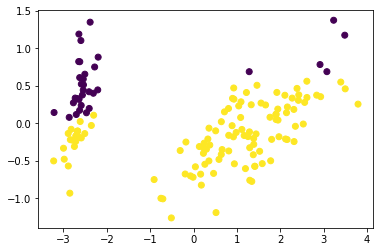

In [ ]:
def plotClusters(A, C, dimX, dimY, dimZ=None, axC=None):
    fig = plt.figure()
    if axC is None:
        ax = plt.subplot(111)
    else:
        ax = axC
    if dimZ is None:
        ax.scatter(dimX, dimY, c=C)
    else:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(dimX, dimY, dimZ, c=C)
    return ax



3. Create a 10×3 plot grid and show 10 different clusterings obtained with the 3 algorithms
(with different initial centroids) on the iris PCA data. Which algorithm produces best
clusterings (here)?

In [ ]:
flag = True
while flag:
    try:
        fig, axs = plt.subplots(10,3, figsize=(25,30))
        fig.tight_layout
        for i in range(10):
            C = getClusterings(iris_numpy, 2)
            for j in range(3):
                axs[i,j] = plotClusters(iris_numpy, C[j], iris_numpy[:, 0], iris_numpy[:, 1], axC=axs[i,j])
                #axs[i,j].set_title('[' + str(i) + ',' + str(j) + ']')
        print('funciona')
        flag = False
    except:
        print('fallo')
        flag= True


fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo


C:\Users\jedaz\AppData\Local\Temp\ipykernel_16164\4143812253.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(10,3, figsize=(25,30))


fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
fallo
